# K-Means Clustering

This notebook will introduce k-means clustering on a toy dataset of blobs (w/ a few noisy points). We will:

- manually implement k-means to see how it works
- visualize the decision regions over the course of training iterations
- use sklearn to easily apply the method
- evaluate clustering performance with the elbow and the silhouette methods

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)

plt.style.use('dark_background')

# Make data

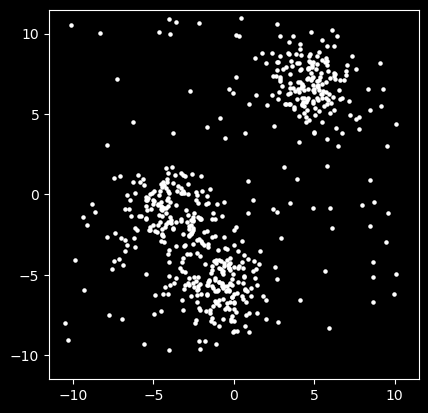

In [75]:
from sklearn.datasets import make_blobs

# Generate synthetic data using make_blobs
X1, _ = make_blobs(n_samples=500,
                   centers=3,
                   cluster_std=1.5,
                   random_state=1
                  )

X1 -= np.mean(X1,axis=0)

# Normalize and add uniform noise
X1 -= np.mean(X1, axis=0)
MAX = np.max(np.abs(X1))
X2 = np.random.uniform(-MAX, MAX, size=(100, 2))

X2 -= np.mean(X2,axis=0)

X = np.concatenate((X1,X2),axis=0)

MAX = np.max(np.abs(X))*1.05

cmap = 'jet'

plt.scatter(X[:,0], X[:,1], c='w', s=5);
plt.xlim(-MAX,MAX)
plt.ylim(-MAX,MAX)
plt.gca().set_aspect('equal')

# Perform kmeans manually

- randomly initialize initial guesses for cluster centroids
- for each data point, find it's closest centroid and assign it that label
- update centroids to average of all data points with its label
- repeat until the centroids converge

# Closer look

In [47]:
def plot_regions(centroids):
    nGrid = 200
    a1 = np.linspace(-MAX,MAX,nGrid)
    a2 = np.linspace(-MAX,MAX,nGrid)

    A1, A2 = np.meshgrid(a1,a2)
    A1 = A1.flatten()
    A2 = A2.flatten()
    A = np.vstack((A1,A2)).T

    distances = np.sqrt(((A - centroids[:, np.newaxis])**2).sum(axis=2))
    B = np.argmin(distances, axis=0)
    
    B = B.reshape(nGrid,nGrid)
    B = np.flipud(B)
    
    return B
# end

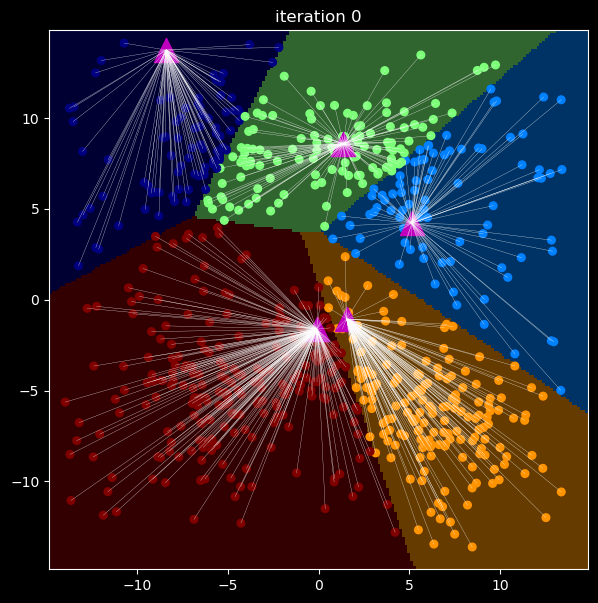

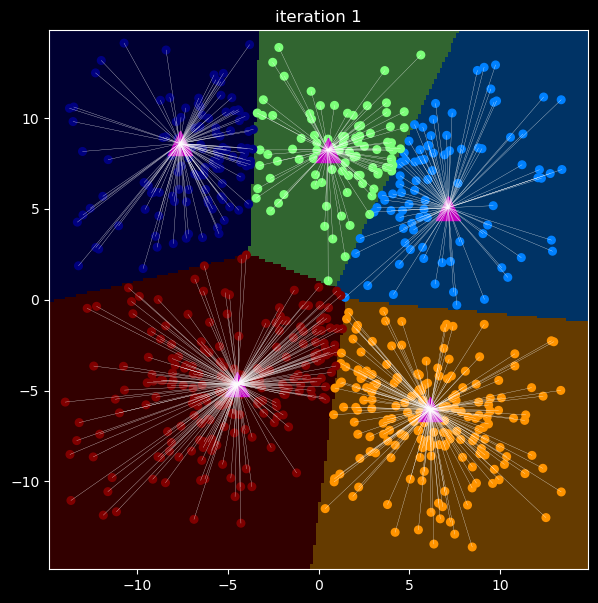

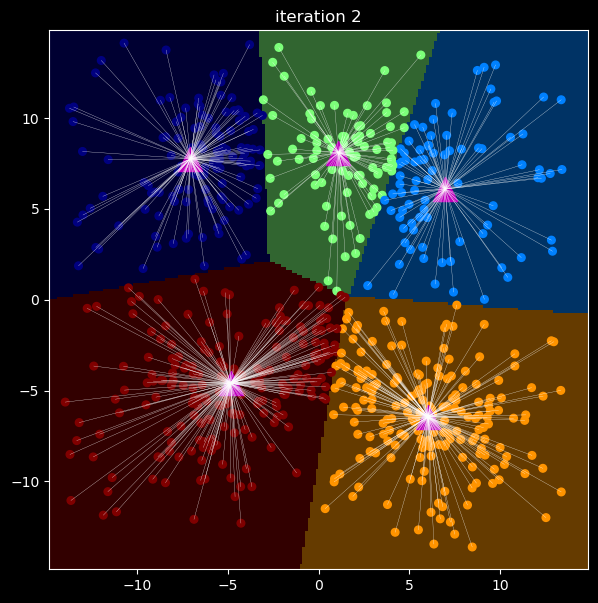

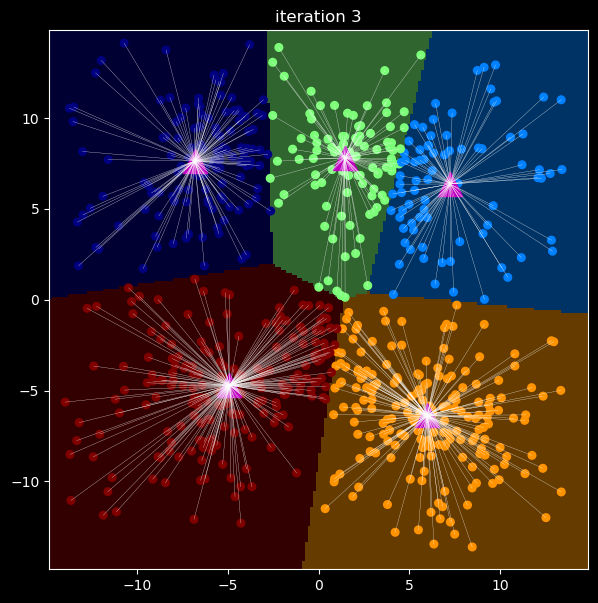

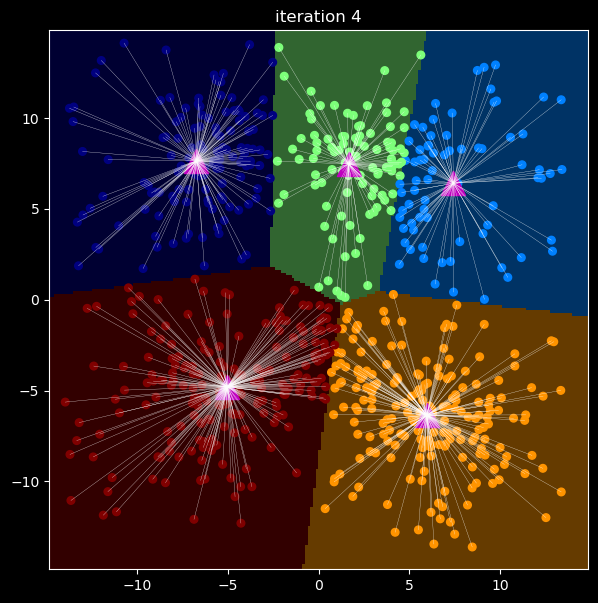

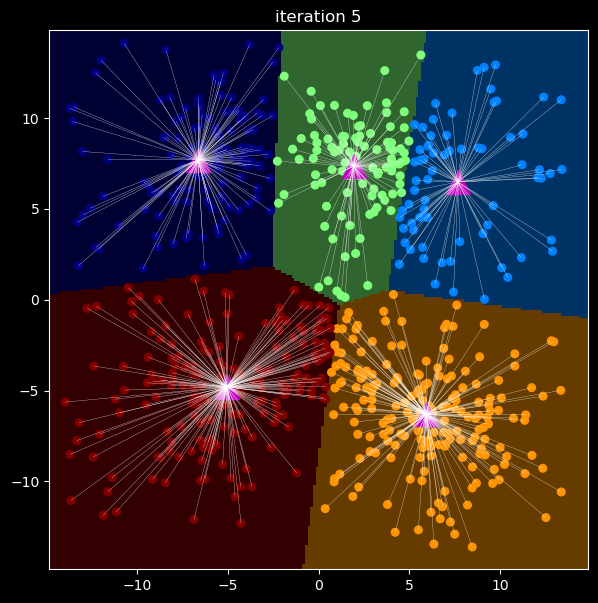

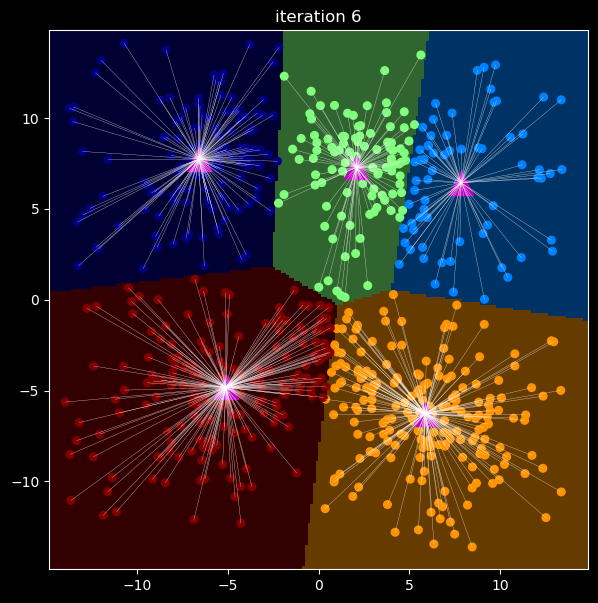

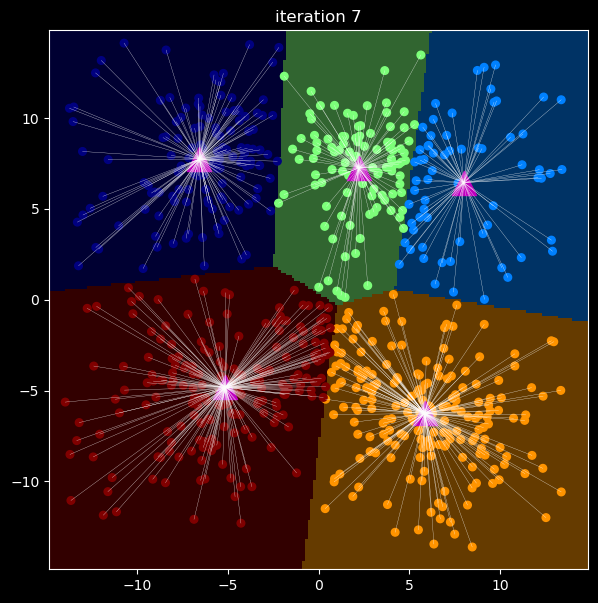

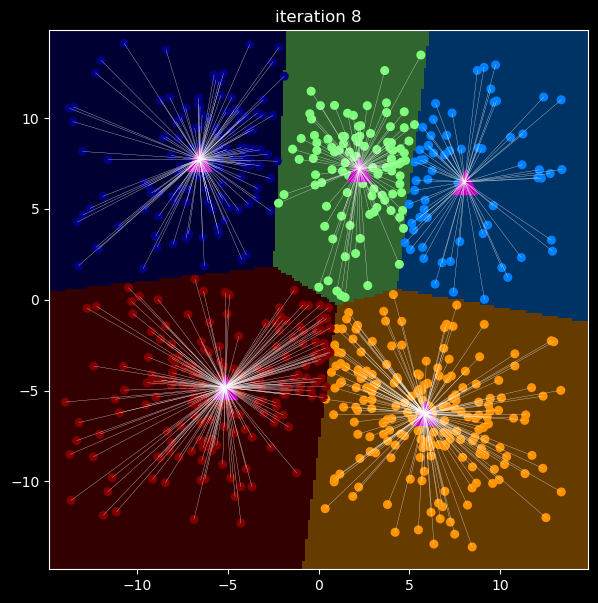

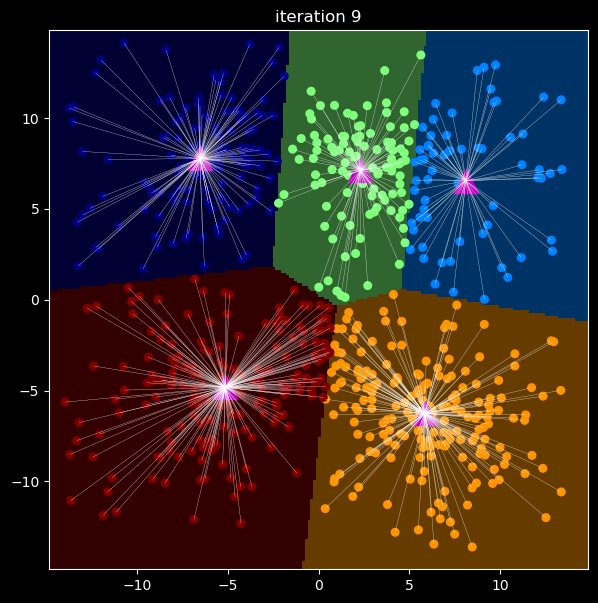

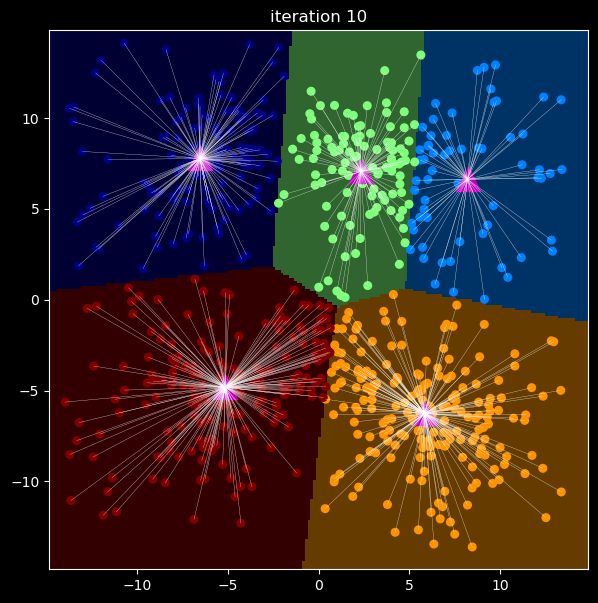

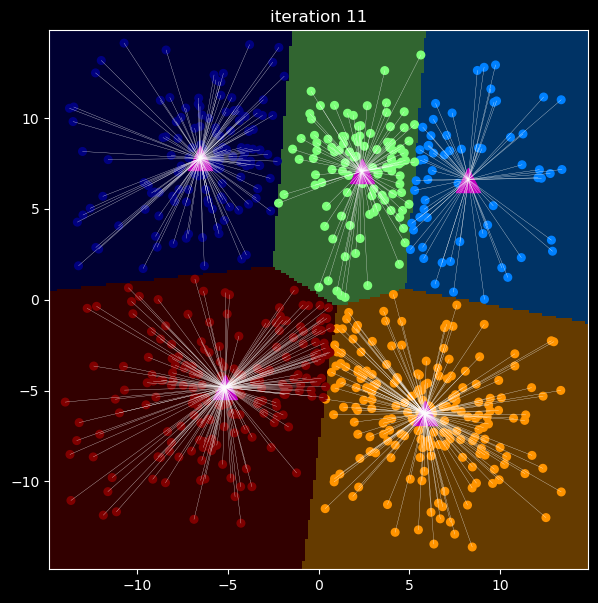

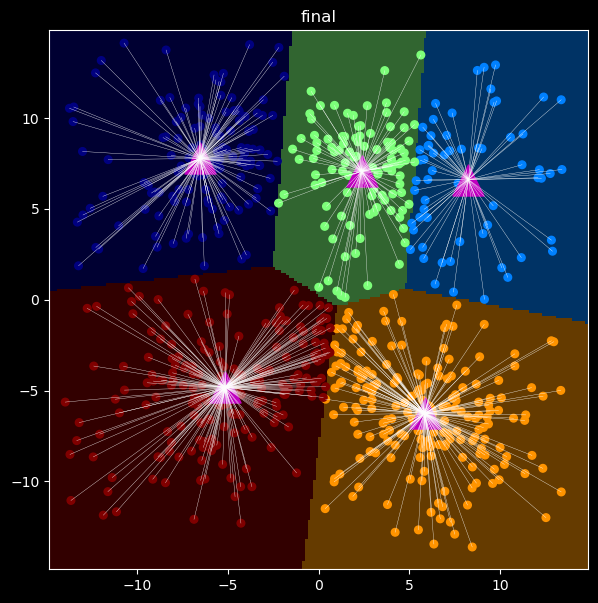

In [49]:
# Define number of clusters
k = 5

# Randomly initialize centroids
centroids = X[np.random.choice(len(X), k, replace=False)]
#centroids = np.random.uniform( -MAX, MAX, size=(k,X.shape[1]) )

max_iters = 100
for i in range(max_iters):
    
    # Assign each data point to the nearest centroid
    distances = np.sqrt(((X - centroids[:, np.newaxis])**2).sum(axis=2))
    labels = np.argmin(distances, axis=0)
    
    B = plot_regions(centroids)
    extent = [-MAX,MAX,-MAX,MAX]
    
    plt.figure(figsize=(7,7))
    plt.imshow(B, interpolation='none', extent=extent,cmap=cmap, alpha=0.4)
    for j in range(X.shape[0]):
        plt.plot([ X[j,0], centroids[labels[j],0] ],
                 [ X[j,1], centroids[labels[j],1] ],
                 c='w', linewidth=0.2);
    # end
    plt.scatter(X[:,0], X[:,1], c=labels, s=30, cmap=cmap);
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='^', s=300, c='m')
    plt.xlim(-MAX,MAX)
    plt.ylim(-MAX,MAX)
    plt.title(f'iteration {i}');
    plt.gca().set_aspect('equal')
    plt.show()
    
    # Update centroids based on the mean of data points in each cluster
    new_centroids = np.empty_like(centroids)
    for i in range(k):
        new_centroids[i] = np.mean(X[labels == i], axis=0)

    # Check for convergence
    if np.allclose(new_centroids, centroids):
        break

    centroids = new_centroids

# end

plt.figure(figsize=(7,7))
plt.imshow(B, interpolation='none', extent=extent,cmap=cmap, alpha=0.4)
for i in range(X.shape[0]):
    plt.plot([ X[i,0], centroids[labels[i],0] ],
             [ X[i,1], centroids[labels[i],1] ],
             c='w', linewidth=0.25);
# end
plt.scatter(X[:,0], X[:,1], c=labels, s=30, cmap=cmap);
plt.scatter(centroids[:, 0], centroids[:, 1], marker='^', s=500, c='m')
plt.xlim(-MAX,MAX)
plt.ylim(-MAX,MAX)
plt.title(f'final');
plt.gca().set_aspect('equal')
plt.show()

# Perform kmeans with sklearn

[0 4 1 0 4 3 0 1 3 2]
[[-5.43954903  7.60574427]
 [ 0.93618011 -2.84247418]
 [-6.13032124 -6.11561058]
 [ 6.73776246 -7.05226542]
 [ 4.08512845  7.36596569]]


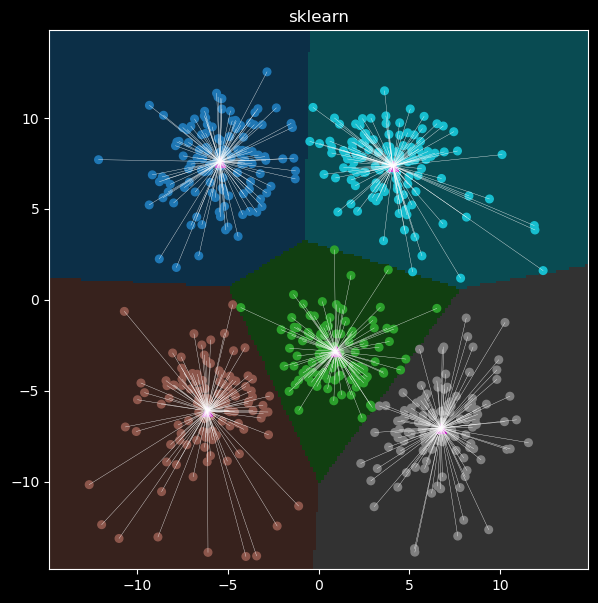

In [68]:
from sklearn.cluster import KMeans

# numer of clusters
k = 5

# create and train model
model = KMeans(n_clusters=k)
model.fit(X)

# predicted labels of training points are stored
labels = model.labels_
print(labels[:10])

# predict new points (or even the training points)
#labels = model.predict(X)

# get cluster centroids
centroids = model.cluster_centers_
print(centroids[:10])

B = plot_regions(centroids)
extent = [-MAX,MAX,-MAX,MAX]

plt.figure(figsize=(7,7))
plt.imshow(B, interpolation='none', extent=extent,cmap=cmap, alpha=0.4)
for i in range(X.shape[0]):
    plt.plot([ X[i,0], centroids[labels[i],0] ],
             [ X[i,1], centroids[labels[i],1] ],
             c='w', linewidth=0.25);
# end
plt.scatter(X[:,0], X[:,1], c=labels, s=30, cmap=cmap);
plt.scatter(centroids[:, 0], centroids[:, 1], marker='^', s=50, c='m')
plt.xlim(-MAX,MAX)
plt.ylim(-MAX,MAX)
plt.title(f'sklearn');
plt.gca().set_aspect('equal')
plt.show()

# Evaluating K-Means Performance

## The Elbow Method and Inertia

The **elbow method** is a commonly used heuristic for selecting the optimal number of clusters $K$ in K-means clustering. It relies on analyzing the **inertia**, which is the *within-cluster sum of squared distances* — a measure of how tightly the data points are clustered around their respective centroids.

The inertia is defined mathematically as:

$$
\text{Inertia} = \sum_{k=1}^{K} \sum_{x_i \in C_k} \| x_i - \mu_k \|^2
$$

Where:
- $x_i \in C_k$ is a data point assigned to cluster $C_k$
- $\mu_k$ is the centroid of cluster $C_k$
- $\| x_i - \mu_k \|^2$ is the squared Euclidean distance between point $x_i$ and its cluster centroid

As the number of clusters $K$ increases, the inertia **always decreases or remains the same** — it is a **monotonically decreasing function** of $K$. This is because adding more clusters reduces the average distance between points and their centroids.

In the elbow method, inertia is plotted as a function of $K$. Initially, adding more clusters yields a large drop in inertia, but after a certain point, the rate of decrease slows. The **elbow point** (where the rate of decrease of inertia slows suddenly) on this plot represents a trade-off between model complexity and explained variance, suggesting a good value for $K$. In practice with real datasets, this elbow point can be subtle, indicating a shotcoming of the elbow method.

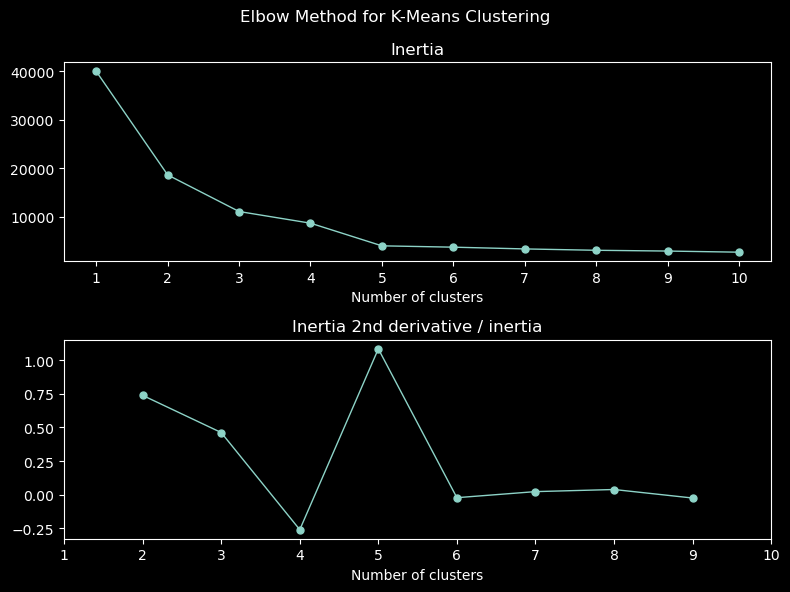

In [56]:
# max number of clusterse to test
k_max = 10

# Calculate within-cluster sum of squares (inertia) for different number of clusters
inertia = []
for i in range(1, k_max + 1):
    # Fit model
    model = KMeans(n_clusters=i)
    model.fit(X)
    
    # Save inertia
    inertia.append(model.inertia_)
# end

# put into series for convenience
inertia = pd.Series(inertia)

# calculate inertia 2nd derivate divided by inertia to find the elbow point
inertia_elbow = inertia.diff().diff().dropna().to_numpy() / inertia.iloc[1:-1].to_numpy()

# Plotting the elbow method graph
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8,6))

plt.suptitle('Elbow Method for K-Means Clustering')

axes[0].plot(range(1, 11), inertia, marker='.', markersize=10, linestyle='-', linewidth=1)
axes[0].set_xlabel('Number of clusters')
axes[0].set_title('Inertia')
axes[0].set_xticks(np.arange(1, 11, 1))

axes[1].plot(range(2, 10), inertia_elbow, marker='.', markersize=10, linestyle='-', linewidth=1)
axes[1].set_title('Elbow Method for K-Means Clustering')
axes[1].set_xlabel('Number of clusters')
axes[1].set_title('Inertia 2nd derivative / inertia')
axes[1].set_xticks(np.arange(1, 11, 1))

plt.tight_layout()

## The Silhouette Method

The **silhouette method** is an alternative to the elbow method. Unlike the elbow method, which considers only the *within-cluster* variance (inertia), the silhouette method accounts for both **within-cluster cohesion** and **between-cluster separation**.

For each data point $x_i$, the silhouette score $s(i)$ is defined as:

$$
s(i) = \frac{b(i) - a(i)}{\max\{a(i), b(i)\}}
$$

Where:
- $a(i)$ is the average distance between $x_i$ and all other points in the same cluster (intra-cluster distance).
- $b(i)$ is the minimum average distance between $x_i$ and all points in the nearest different cluster (inter-cluster distance).

The silhouette score ranges from $-1$ to $1$:
- Values close to $1$ indicate that the point is well-matched to its own cluster and poorly matched to neighboring clusters.
- Values near $0$ indicate overlapping clusters.
- Negative values indicate that the point may have been assigned to the wrong cluster.

To evaluate the overall clustering performance, the average silhouette score across all points is computed. The **optimal number of clusters** is the one that **maximizes the average silhouette score**, indicating well-separated and cohesive clusters.


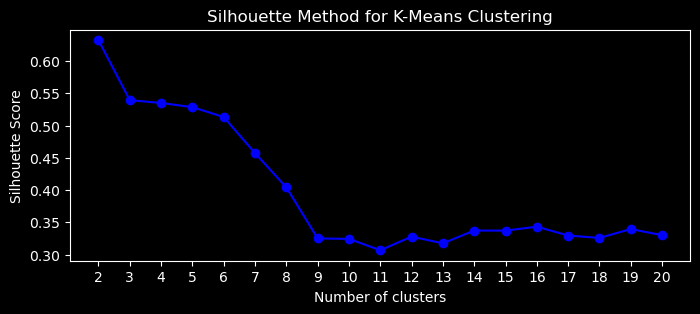

In [77]:
from sklearn.metrics import silhouette_score

# max number of clusterse to test
k_max = 20

silhouette = []
for i in range(2, k_max+1):
    # Fit model
    model = KMeans(n_clusters=i)
    labels = model.fit_predict(X)
    
    # Calculate silhouette score
    silhouette.append( silhouette_score(X, labels) )
# emd

# Plotting the silhouette method graph
plt.figure(figsize=(8, 3))
plt.plot(range(2, k_max+1), silhouette, marker='o', linestyle='-', color='b')
plt.title('Silhouette Method for K-Means Clustering')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.xticks(np.arange(2, k_max+1, 1))
plt.show()

# Evaluating individual cluster separation w/ silhouette scores

We can create histograms and cumulative distributions of the silhouette scores of points in each separate cluster. Clusters (and their constituent points) with higher average silhouette are better separated

[[-4.40395149 -1.0202869 ]
 [ 4.48624357  6.61266012]
 [-0.43853953 -5.54157423]]


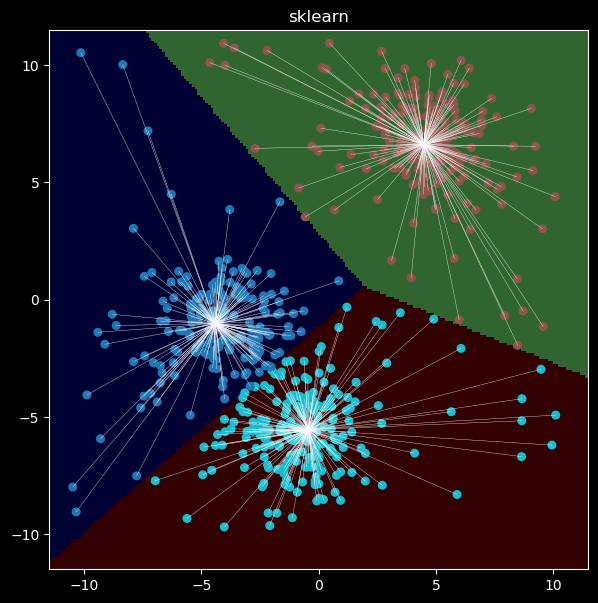

0 0.4701669557044843
1 0.6788980089457419
2 0.46502054606768156


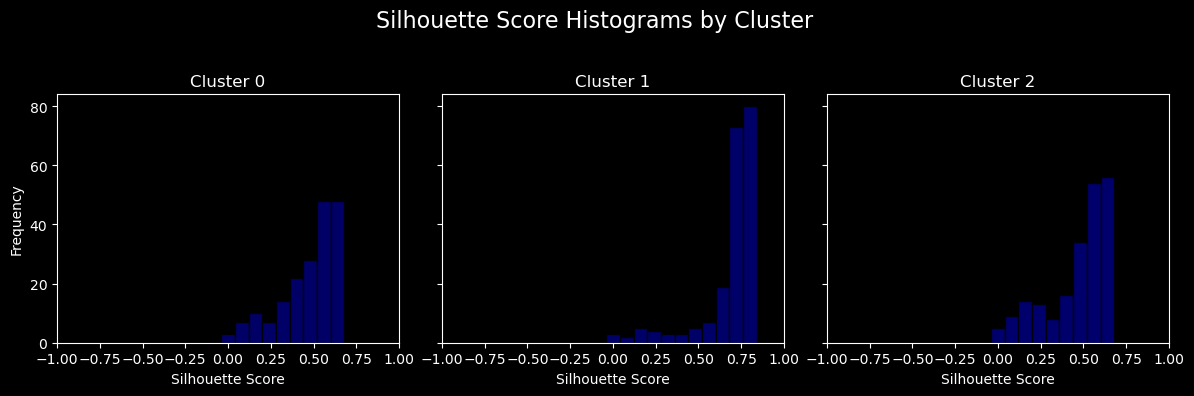

In [81]:
from sklearn.metrics import silhouette_samples
from matplotlib.cm import get_cmap

# Choose number of clusters
n_clusters = 3

# Fit model and compute silhouette scores
model = KMeans(n_clusters=n_clusters, random_state=0)
labels = model.fit_predict(X)

# get silhouette scores of indiviual samples
sil_vals = silhouette_samples(X, labels)

# get cluster centroids
centroids = model.cluster_centers_
print(centroids[:10])

B = plot_regions(centroids)
extent = [-MAX,MAX,-MAX,MAX]

plt.figure(figsize=(7,7))
plt.imshow(B, interpolation='none', extent=extent,cmap='jet', alpha=0.4)
for i in range(X.shape[0]):
    plt.plot([ X[i,0], centroids[labels[i],0] ],
             [ X[i,1], centroids[labels[i],1] ],
             c='w', linewidth=0.25);
# end
plt.scatter(X[:,0], X[:,1], c=labels, s=30, cmap=cmap);
plt.scatter(centroids[:, 0], centroids[:, 1], marker='^', s=50, c='m')
plt.xlim(-MAX,MAX)
plt.ylim(-MAX,MAX)
plt.title(f'sklearn');
plt.gca().set_aspect('equal')
plt.show()

# Create histograms
cmap = get_cmap("jet")
fig, axes = plt.subplots(1, n_clusters, figsize=(4 * n_clusters, 4), sharey=True)

for i in range(n_clusters):
    ax = axes[i]
    cluster_sil_vals = sil_vals[labels == i]
    print(i, cluster_sil_vals.mean())
    
    ax.hist(cluster_sil_vals, bins=25, range=(-1, 1), color=cmap(i), edgecolor='black', alpha=0.8)
    ax.set_title(f'Cluster {i}')
    ax.set_xlim(-1, 1)
    ax.set_xlabel('Silhouette Score')
    if i == 0:
        ax.set_ylabel('Frequency')

plt.suptitle('Silhouette Score Histograms by Cluster', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

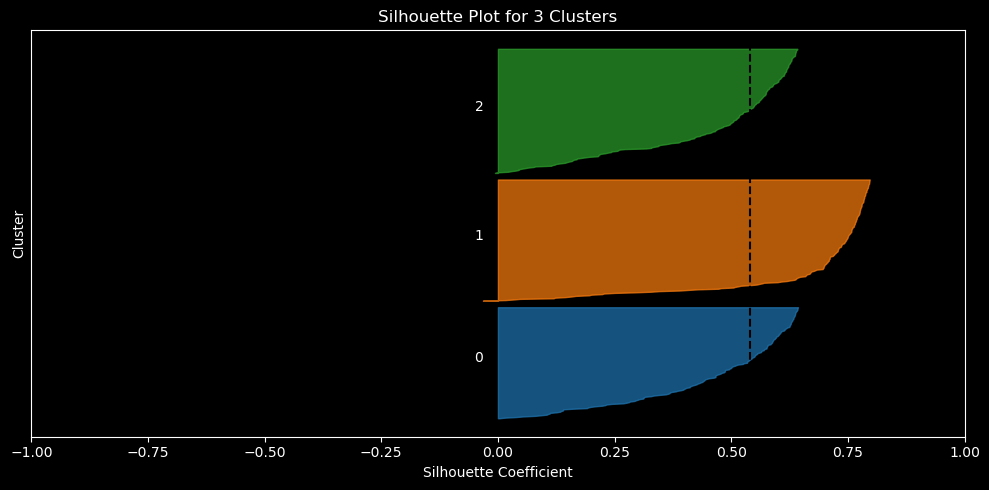

In [82]:
# get silhouette scores of indiviual samples
sil_vals = silhouette_samples(X, labels)

# Plot silhouette chart
fig, ax = plt.subplots(figsize=(10, 5))
y_lower = 10
cmap = get_cmap("tab10")

for i in range(n_clusters):
    # Collect silhouette values for samples in cluster i, and sort them
    cluster_sil_vals = sil_vals[labels == i]
    cluster_sil_vals.sort()
    
    size = len(cluster_sil_vals)
    y_upper = y_lower + size
    
    color = cmap(i)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_sil_vals, facecolor=color, edgecolor=color, alpha=0.7)
    ax.text(-0.05, y_lower + 0.5 * size, str(i))
    
    y_lower = y_upper + 10  # 10 for spacing between clusters

ax.axvline(x=silhouette_score(X, labels), color="k", linestyle="--")
ax.set_xlabel("Silhouette Coefficient")
ax.set_ylabel("Cluster")
ax.set_title(f"Silhouette Plot for {n_clusters} Clusters")
ax.set_yticks([])
ax.set_xlim([-1, 1])
plt.tight_layout()
plt.show()